# LIGHTGBM

## importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)


## read the dataset

In [2]:

data = pd.read_csv('combined_dataset.csv')  


In [3]:

# Data Preprocessing
print("Original shape:", data.shape)


Original shape: (28789809, 13)


In [4]:
# Handle missing values
data = data.dropna()
print("After dropping NA:", data.shape)


After dropping NA: (28789809, 13)


## count of each class

In [5]:
data["Label"].value_counts()

Label
1    20007392
0     8782417
Name: count, dtype: int64

## splitting to trainng and testng

In [6]:

# Feature-Target Split
X = data.drop('Label', axis=1)
y = data['Label']

# Train-Test Split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")



Train samples: 20152866, Test samples: 8636943


## training the model

In [7]:


# --- 2. Train the LightGBM Model ---

# --- Handling Class Weighting ---
# The user wants to pay more attention to the 'Malicious' class (label 1).
# In this specific dataset, the 'Malicious' class is the MAJORITY.
# Standard 'scale_pos_weight' is used to boost the minority class.
# To amplify the focus on the majority class (1), we can set a weight > 1.
# A simple way is to use the ratio of the majority class count to the minority class count.
neg_samples = np.sum(y_train == 0) # Minority class (Benign)
pos_samples = np.sum(y_train == 1) # Majority class (Malicious)

# We set the weight for the positive class (1) to be > 1 to increase its importance.
if neg_samples > 0:
    # This ratio will be > 1, increasing the penalty for misclassifying the positive class.
    scale_pos_weight_value = pos_samples / neg_samples
else:
    scale_pos_weight_value = 1 # Default case if no negative samples exist

print(f"\nCalculated 'scale_pos_weight': {scale_pos_weight_value:.2f} (to focus on the majority class)")



Calculated 'scale_pos_weight': 2.28 (to focus on the majority class)


### hyperparameters

In [8]:

lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',  # Area Under Curve is a good metric for imbalanced data
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=scale_pos_weight_value # Weight to focus on the positive class (1)
)

In [9]:


print("\nTraining LightGBM model...")
# Use early stopping to find the best number of trees and prevent overfitting.
# The model will stop training if the 'auc' on the test set doesn't improve for 100 rounds.
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='auc',
         callbacks=[lgb.early_stopping(100, verbose=True)])




Training LightGBM model...
[LightGBM] [Info] Number of positive: 14005174, number of negative: 6147692
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.824167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 20152866, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.694947 -> initscore=0.823350
[LightGBM] [Info] Start training from score 0.823350
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[465]	valid_0's auc: 0.997912


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, metric='auc',
               n_estimators=800, n_jobs=-1, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1,
               scale_pos_weight=2.2781190079138645, subsample=0.8)

## Evaluation


--- Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99   2634725
   Malicious       1.00      0.99      1.00   6002218

    accuracy                           0.99   8636943
   macro avg       0.99      1.00      0.99   8636943
weighted avg       0.99      0.99      0.99   8636943

Accuracy: 0.9938
Precision: 0.9999
Recall (Sensitivity): 0.9912
F1-Score: 0.9955
AUC-ROC Score: 0.9979

Confusion Matrix:
[[2634092     633]
 [  52832 5949386]]


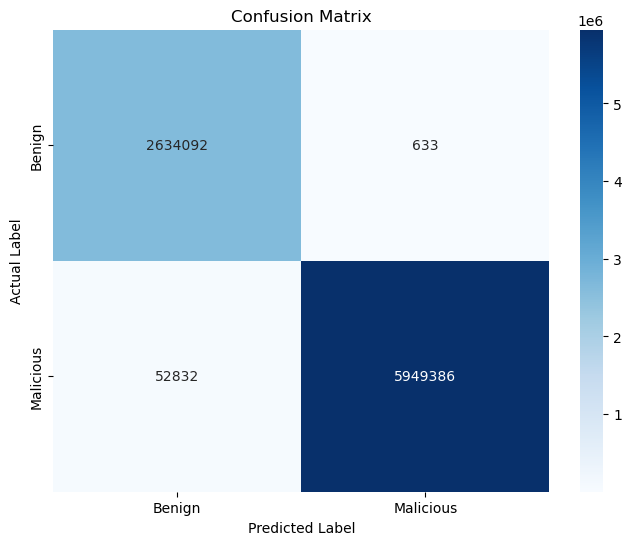

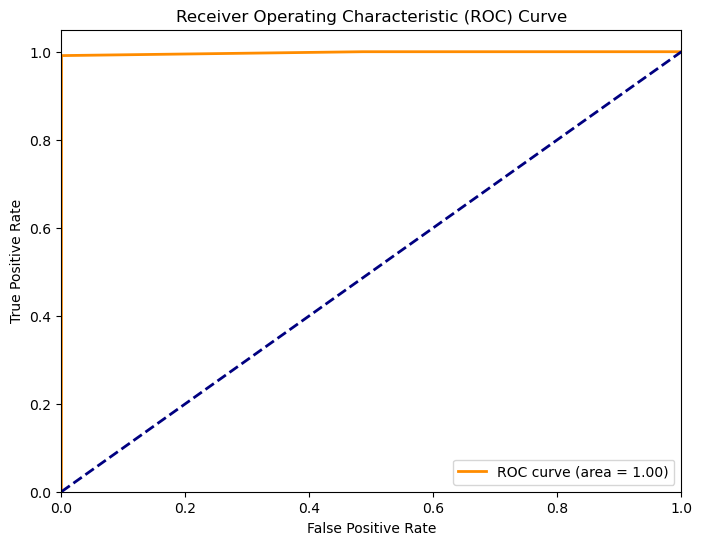

In [10]:

# --- 3. Evaluate the Model ---

print("\n--- Model Evaluation ---")
# Make predictions on the test data
y_pred_proba = lgbm.predict_proba(X_test)[:, 1] # Probabilities for the positive class (Malicious)
y_pred = lgbm.predict(X_test) # Class predictions (0 or 1)

# Define class names for the report (assuming 0 is Benign, 1 is Malicious)
class_names = ['Benign', 'Malicious']

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Print individual metrics for clarity
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Generate and plot the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## save the model to use in simulation


--- Feature Importance ---
Feature importances based on the number of times a feature is used in a split:
          Feature  Importance
0       id.resp_p        4973
3        duration        3072
6      conn_state        1139
9   orig_ip_bytes        1022
8       orig_pkts         819
4      orig_bytes         717
10      resp_pkts         677
11  resp_ip_bytes         494
1           proto         491
5      resp_bytes         414
2         service         132
7    missed_bytes           0

Plotting the most important features...


<Figure size 1200x1000 with 0 Axes>

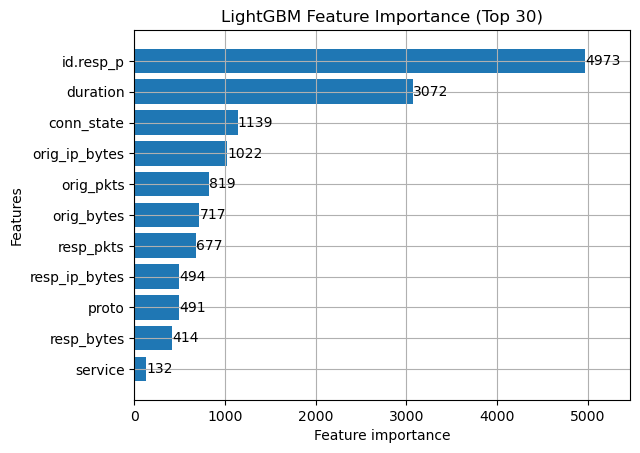

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- 4. Feature Importance Analysis ---

print("\n--- Feature Importance ---")

# Create a pandas DataFrame for easier viewing
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display all features and their importance scores
print("Feature importances based on the number of times a feature is used in a split:")
print(feature_imp)


# --- Plotting Feature Importance ---

print("\nPlotting the most important features...")

# Create a figure and axes for the plot
plt.figure(figsize=(12, 10))

# Use the built-in plot_importance function from LightGBM
# max_num_features controls how many top features to display
lgb.plot_importance(lgbm, max_num_features=30, height=0.8) 

plt.title("LightGBM Feature Importance (Top 30)")
plt.show()

In [12]:
import joblib # Import the joblib library for saving/loading models
# Define the filename for the saved model
model_filename = '800lgbm_iot_model.joblib'

# Save the trained model to a file
print(f"\nSaving model to {model_filename}...")
joblib.dump(lgbm, model_filename)
print("Model saved successfully.")


Saving model to 800lgbm_iot_model.joblib...
Model saved successfully.
